In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


## Dataset

In [ ]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [ ]:
IMAGE_SIZE = [64,64]

images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        # (width, height) = (im.width // 4, im.height // 4)
        im_resized = im.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))
        images.append(np.array(im_resized))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [ ]:
T=1000

#linear schedule
# beta = np.linspace(1e-4, 0.015, T)
# alpha = 1-beta
# alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
# alphaBar = np.array(alphaBar)

tValues = np.arange(0,T)

#Cosine schedule
def f(t):
    return np.cos((t/T + 0.008)/(1 + 0.008) * np.pi/2)**2

alphaBar = f(tValues)
alpha = (alphaBar[1:])/(alphaBar[0:-1])
alpha = np.insert(alpha, 0, alphaBar[0])
beta = 1 - alpha




def forwardStep(x0Image,t):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy


# Make a combination of all images and all possible t values and shuffle them
# trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
# shuffle(trainComb)
# dataSize = len(trainComb)

#This generator provides all the timesteps for all images --> A huge dataset with comparably low variation
# def generator():
#     for fileIdx,tValue in trainComb:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         image = tf.convert_to_tensor(images[fileIdx])
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.95, 1.05)
#         image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = image.numpy()
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

# Generator that outputs random time steps per image
# repeats=2
# def generator():
#     for im in images:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         # image = tf.convert_to_tensor(im)
#         # image = tf.image.random_brightness(image, 0.1)
#         # image = tf.image.random_contrast(image, 0.95, 1.05)
#         # image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = (im/127.5)-1
#         tValues = np.random.choice(T,repeats, replace=False)
#         for tValue in tValues:
#             tValue = np.random.randint(0,T)
#             noise, noisy = forwardStep(x0, tValue)
#             yield noisy, noise, [tValue], x0

# Generator that outputs nSamplesPerTStep for ever t in (0,T)
samplesPerTStep=10
trainComb = []
for t in range(T):
    randomFiles = np.random.choice(np.arange(0,len(images)), samplesPerTStep, replace=False)
    for randomFile in randomFiles:
        trainComb.append(( randomFile, t))
shuffle(trainComb)
dataSize = len(trainComb)
print(dataSize)

def generator():
    for fileIdx,tValue in trainComb:
        im = images[fileIdx]
        x0 = (im/127.5)-1
        noise, noisy = forwardStep(x0, tValue)
        yield noisy, noise, [tValue], x0

10000


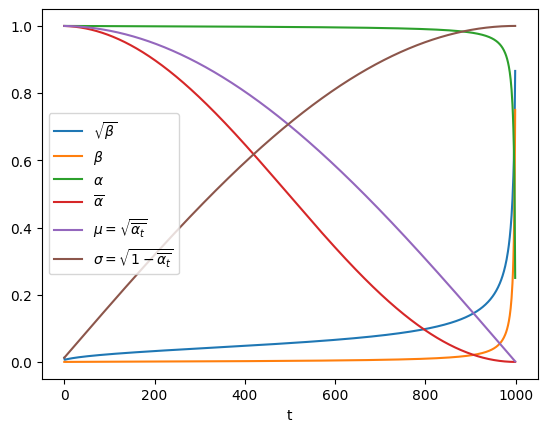

In [ ]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(beta, label=r"$\beta$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
# _ = plt.plot( (1-alpha)/(np.sqrt(1-np.array(alphaBar)*np.sqrt(alpha))) , label=r"$\frac{1-\alpha}{\sqrt{1-\overline{\alpha}}*\sqrt{\alpha}}}$")
_ = plt.legend()
_ = plt.xlabel("t")

In [ ]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [ ]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[653]
(64, 64, 3)
(64, 64, 3)


In [ ]:
test = next(g)
np.max(test[1])

4.079590608912265

Text(0.5, 1.0, 'Noise')

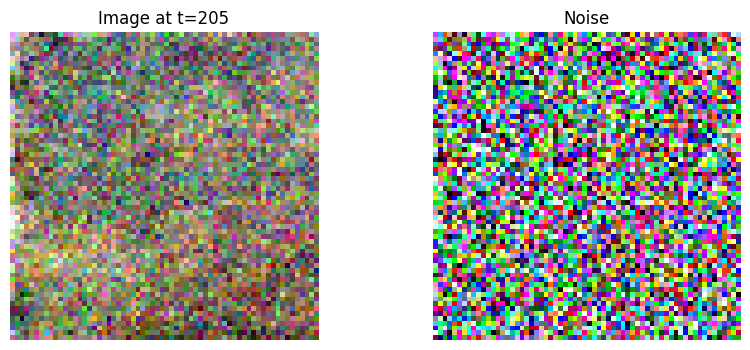

In [ ]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]))
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]))
plt.axis('off')
plt.title("Noise")

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 63.5, 63.5, -0.5)

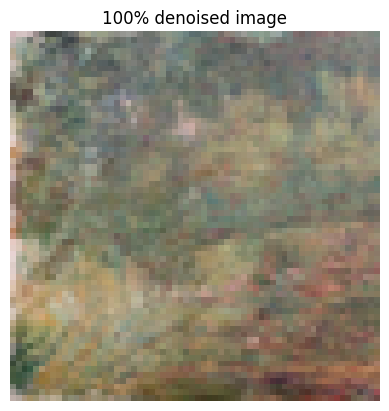

In [ ]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [ ]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

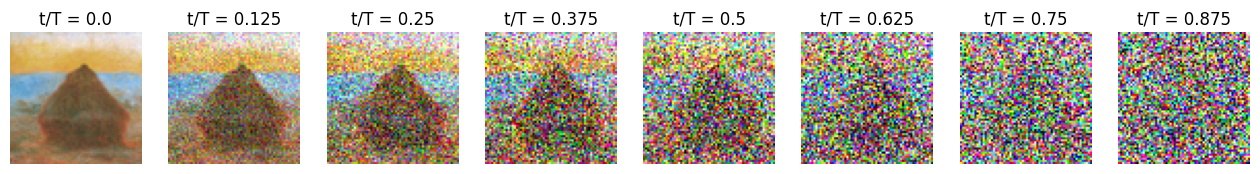

In [ ]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]))
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [ ]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStepTesting(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t>1:
        randNoise= np.random.normal(0,1,xt.shape)
    else:
        randNoise= np.zeros(xt.shape)
   
    # estimate mean
    meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))
    # compute variance
    betaPred = np.sqrt(beta[t])
    sample = meanPred + betaPred*randNoise
    noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise


variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))
def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = tf.random.normal(xt.shape)
    else:
        randNoise= tf.zeros(xt.shape)

    # xtPrev = predX0 * (np.sqrt(alphaBar[t-1])*beta[t]) / ((1-alphaBar[t])) + xt*((1-alphaBar[t-1])*np.sqrt(alpha[t]))/((1-alphaBar[t])) + sigPred[t]*randNoise
       
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + variance[t] * randNoise
    # xtPrev = np.clip(xtPrev, -1.0, 1.0)

    return xtPrev

def backwardStepDDIM(xt, t, predNoise, sig=0):
    if sig>0:
        if t>1:
            randNoise = tf.random.normal(xt.shape)
        else:
            randNoise= tf.zeros(xt.shape)
    else:
        randNoise=0

    if t==1:
        xtPrev = xt 
    else:
        predX0 = (xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])
        xtPrev = np.sqrt(alphaBar[t-1]) * predX0 + np.sqrt(1-alphaBar[t-1]-sig**2)*predNoise + sig*randNoise

    return xtPrev


for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStepTesting(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

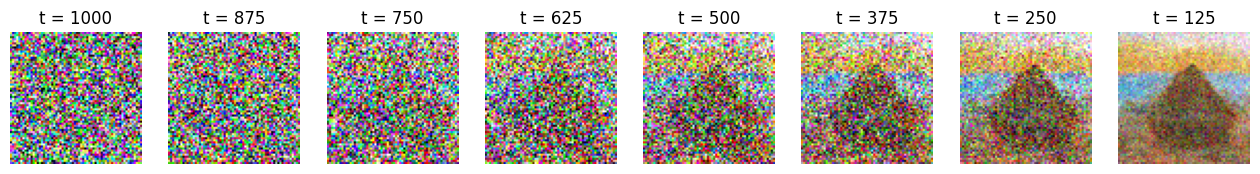

In [ ]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]))
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

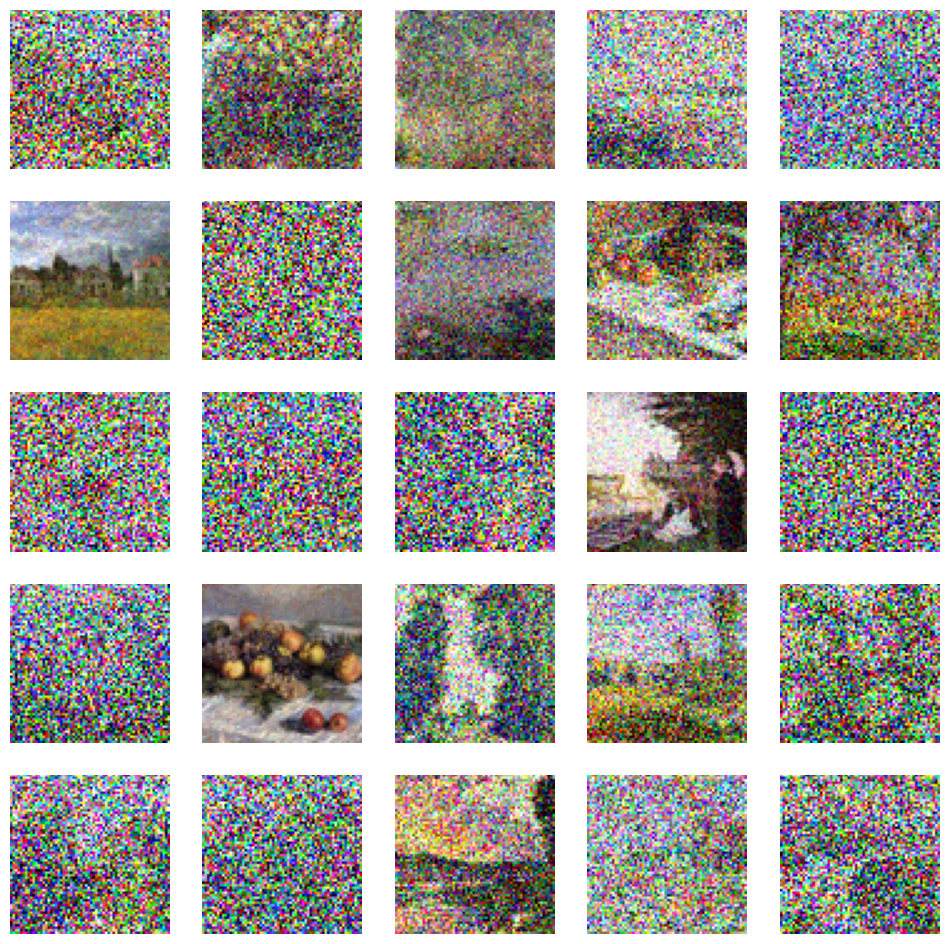

In [ ]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))
datasetList = list(dataset.take(25))

plt.figure(figsize=(12,12))
for i in range(5*5):
    plt.subplot(5,5,i+1)
    _ = plt.imshow(np.clip(datasetList[i][0].numpy()/2+0.5, 0,1))
    _ = plt.axis("off")


## Tensorflow

In [ ]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "SimpleUnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 64, 64, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 64, 64, 64)           256       ['conv2d_35[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv2d_36 (Conv2D)          (None, 32, 32, 128)          73856     ['batch_normalization

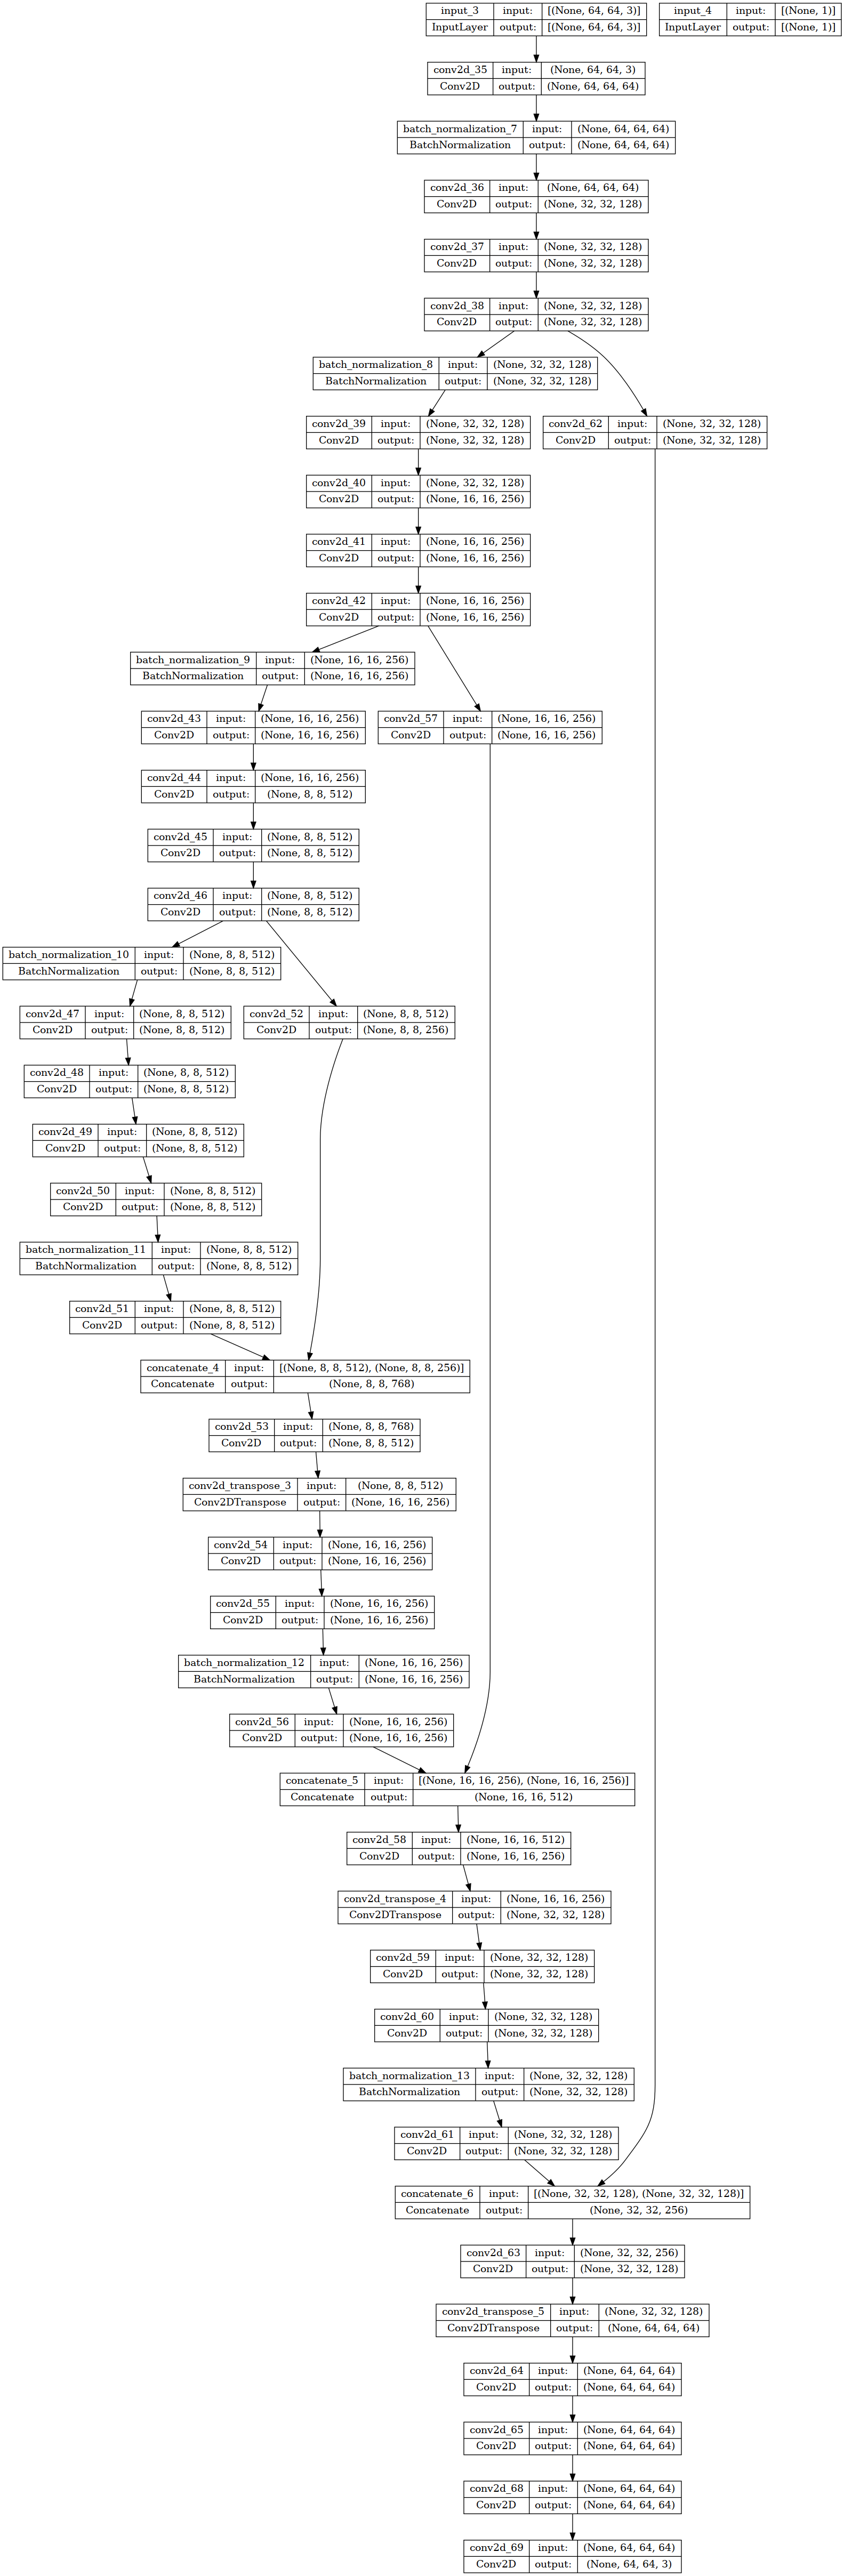

In [ ]:

def createSimpleUnet(K=1):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    # embeddedStep = tf.keras.layers.Embedding(T, IMAGE_SIZE[0])(stepInput)
    # stepMap = tf.repeat(embeddedStep, IMAGE_SIZE[0], axis=0)
    # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    # concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(inputs)
    xDown1 = tf.keras.layers.BatchNormalization()(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", strides=2, activation="relu")(xDown1)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu"  )(xDown1)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu"  )(xDown1)
    #128
    
    xDown2 = tf.keras.layers.BatchNormalization()(xDown1)
    xDown2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown2)
    #64

    xDown3 = tf.keras.layers.BatchNormalization()(xDown2)
    xDown3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", strides=2, activation="relu")(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu"  )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu"  )(xDown3)
    #32

    xCenter = tf.keras.layers.BatchNormalization()(xDown3)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)

    # stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=8, padding="same")(stepMap)
    # concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu")(xCenter)
    #32x32


    xUp3 = tf.keras.layers.BatchNormalization()(xCenter)
    xUp3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu")(xUp3)
    xDown3Concat = tf.keras.layers.Conv2D(K*32, 1, padding="same")(xDown3)
    xConcat3 = tf.keras.layers.Concatenate()([xUp3, xDown3Concat])
    xUp3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xConcat3)
    xUp3 = tf.keras.layers.Conv2DTranspose(K*32, 3, padding="same", strides=2, activation="relu")(xUp3)
    xUp3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xUp3)
    xUp3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xUp3)
    #64x64

    xUp2 = tf.keras.layers.BatchNormalization()(xUp3)
    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu")(xUp2)
    xDown2Concat = tf.keras.layers.Conv2D(K*32, 1, padding="same")(xDown2)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2Concat])
    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(K*16, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xUp2)
    xUp2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xUp2)
    #128x128

    xUp1 = tf.keras.layers.BatchNormalization()(xUp2)
    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu")(xUp1)
    xDown1Concat = tf.keras.layers.Conv2D(K*16, 1, padding="same")(xDown1)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1Concat])
    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(K*8, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xUp1)
    xUp1 = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xUp1)
    #256x256

    xDown1InConcat = tf.keras.layers.Conv2D(K*8, 1, padding="same")(xDown1In)
    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1InConcat])
    x = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu")(xUp1)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnet")


model = createSimpleUnet(K=8)

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [ ]:
L2=0

def downscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    xRes = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)
    
    return added


def upscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)

    return added


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)


def centerBlock(xIn, stepMap, ch, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    xRes = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    concatCenter = tf.keras.layers.Concatenate()([xRes, stepMap])

    x = tf.keras.layers.BatchNormalization()(concatCenter)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = nonLocalBlock(x, ch)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

    return x + xRes

def get_timestep_embedding(timesteps, embedding_dim):

  half_dim = embedding_dim // 2
  emb = np.log(10000) / (half_dim - 1)
  emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
  emb = tf.cast(timesteps, dtype=tf.float32) * emb[None, :]
  emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
  if embedding_dim % 2 == 1:  # zero pad
    emb = tf.pad(emb, [[0, 0], [0, 1]])
  return tf.cast(emb, tf.float32)




def createUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    # embeddedStep = tf.keras.layers.Embedding(T, IMAGE_SIZE[0])(stepInput)
    # stepMap = tf.repeat(embeddedStep, IMAGE_SIZE[0], axis=0)
    # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))
    stepMap = tf.keras.layers.Reshape((*IMAGE_SIZE, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]*IMAGE_SIZE[1]))

    concatInput = tf.keras.layers.Concatenate(axis=-1)([inputs, stepMap])

    xDown2 = tf.keras.layers.BatchNormalization()(concatInput)
    xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)
    xDown2 = tf.keras.layers.BatchNormalization()(xDown2)
    xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)
    
    xDown4 = downscaleBlock(xDown2, K*2, K*4, 3)
    #128
    stepMap4 = tf.keras.layers.Reshape((IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]//2*IMAGE_SIZE[1]//2))
    concatDown4 = tf.keras.layers.Concatenate()([xDown4, stepMap4]) 
    xDown4 = tf.keras.layers.BatchNormalization()(concatDown4)
    xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
    xDown4 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)
    xDown4 = tf.keras.layers.BatchNormalization()(xDown4)
    xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
    xDown4 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)

    xDown8 = downscaleBlock(xDown4, K*4, K*8, 3)
    #64
    stepMap8 = tf.keras.layers.Reshape((IMAGE_SIZE[0]//4, IMAGE_SIZE[1]//4, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]//4*IMAGE_SIZE[1]//4))
    concatDown8 = tf.keras.layers.Concatenate()([xDown8, stepMap8]) 
    xDown8 = tf.keras.layers.BatchNormalization()(concatDown8)
    xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
    xDown8 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)
    xDown8 = tf.keras.layers.BatchNormalization()(xDown8)
    xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
    xDown8 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)

    xDown16 = downscaleBlock(xDown8, K*8, K*16, 3)
    #32
    stepMap16 = tf.keras.layers.Reshape((IMAGE_SIZE[0]//8, IMAGE_SIZE[1]//8, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]//8*IMAGE_SIZE[1]//8))
    concatDown16 = tf.keras.layers.Concatenate()([xDown16, stepMap16]) 
    xDown16 = tf.keras.layers.BatchNormalization()(concatDown16)
    xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
    xDown16 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)
    xDown16 = tf.keras.layers.BatchNormalization()(xDown16)
    xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
    xDown16 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)

    xDown32 = downscaleBlock(xDown16, K*16, K*32, 3)
    #16x16
    stepMap32 = tf.keras.layers.Reshape((IMAGE_SIZE[0]//16, IMAGE_SIZE[1]//16, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]//16*IMAGE_SIZE[1]//16))
    concatDown32 = tf.keras.layers.Concatenate()([xDown32, stepMap32]) 
    xDown32 = tf.keras.layers.BatchNormalization()(concatDown32)
    xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
    xDown32 = tf.keras.layers.Conv2D(K*32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)
    xDown32 = tf.keras.layers.BatchNormalization()(xDown32)
    xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
    xDown32 = tf.keras.layers.Conv2D(K*32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

    xCenter = centerBlock(xDown32, stepMap32, K*32, 3)
    #16x16

    xUp16 = upscaleBlock(xCenter, K*32, K*16, 3)
    #32x32
    xConcat16 = tf.keras.layers.Conv2D(K*16, 1)(xDown16)
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xConcat16])
    xUp16 = tf.keras.layers.BatchNormalization()(xConcat16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
    xUp16=tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

    xUp8 = upscaleBlock(xUp16, K*16, K*8, 3)
    #64
    xConcat8 = tf.keras.layers.Conv2D(K*8, 1)(xDown8)
    xConcat8 = tf.keras.layers.Concatenate()([xConcat8, xUp8])
    xUp8 = tf.keras.layers.BatchNormalization()(xConcat8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
    xUp8=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

    xUp4 = upscaleBlock(xUp8, K*8, K*4, 3)
    #128
    xConcat4 = tf.keras.layers.Conv2D(K*4, 1)(xDown4)
    xConcat4 = tf.keras.layers.Concatenate()([xConcat4, xUp4])
    xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp2 = upscaleBlock(xUp4, K*4, K*2, 3)
    #256
    xConcat2 = tf.keras.layers.Conv2D(K*2, 1)(xDown2)
    xConcat2 = tf.keras.layers.Concatenate()([xConcat2, xUp2])
    
    x = tf.keras.layers.BatchNormalization()(xConcat2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_T{}_K{}".format(T,K))


# model = createUnet(K=4)

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [ ]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "unet_T600_K4epoch_110"))
    startEpoch=111
else:
    startEpoch=0

In [ ]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
  initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(1,T)[::-1]:
      pred = model((samples[-1], tf.constant([t, t, t])), training=False)
      xt = samples[-1]
      
      # sample, noise = backwardStep(xt, t, x0Pred=predX0)
      sample = backwardStep(xt, t, predNoise=pred)

      samples.append(sample)

  _ = plt.figure(figsize=(12,8))

  sampleIdx = np.linspace(1, T-1, 5)

  for j in range(3):
    for i in range(5):
        _ = plt.subplot(3, 5, j*5+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        if summary_writer is not None:
           with summary_writer.as_default():
              tf.summary.image("Training data", postprocessImage(samples[int(sampleIdx[-1])]), step=maxStep*epoch+step)
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [ ]:
class MSESSIMLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super().__init__(name="MSE_SSIM_Loss")
        assert(alpha<1.0)
        self.alpha = tf.constant(alpha)
        
    def call(self, yTrue, yPred):
        mse =  tf.math.reduce_mean(tf.math.square(yPred - yTrue))
        ssim = tf.image.ssim(tf.clip_by_value(yPred,-1,1)/2+0.5, tf.clip_by_value(yTrue,-1,1)/2+0.5, max_val=1.0)
        ssimLoss =  1-tf.math.reduce_mean(ssim, axis=-1)
        return (1-self.alpha)*mse + self.alpha*ssimLoss

testLoss = MSESSIMLoss(0.2)
testLoss(tf.ones([1,20,20,3]), tf.ones([1,20,20,3])*0.9)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0084743025>

In [ ]:

BATCH_SIZE=64
LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=10
epochs = 1001
saveModel=False



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
# lossFn = tf.keras.losses.KLDivergence()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = MSESSIMLoss(0.1)

mseMetric = tf.keras.metrics.MeanSquaredError()

# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
# datasetShuffled = dataset.shuffle(200)
batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(noisyImage, noise, t):
    with tf.GradientTape() as tape:
        predicted = model((noisyImage, t), training=True) 

        loss = lossFn(predicted, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    mseMetric.update_state(predicted,noise)

    return loss, predicted



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            # ssim = tf.image.ssim(postprocessImage(predictedImage), postprocessImage(noise), max_val=1.0)
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, mseMetric.result().numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', mseMetric.result().numpy(), step=maxStep*epoch+step)
                # tf.summary.scalar('ssim', tf.math.reduce_mean(ssim), step=maxStep*epoch+step)
                summary_writer.flush()
        
    if epoch % SAVE_IMAGE_INTERVAL==0:
        print("Generate images")
        saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    mseMetric.reset_state()

    if saveModel:
      model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0
Epoch 0/Step 0, Loss: 1.0059
Epoch 0/Step 5, Loss: 1.0012
Epoch 0/Step 10, Loss: 0.9992
Epoch 0/Step 15, Loss: 0.9949
Epoch 0/Step 20, Loss: 0.9847
Epoch 0/Step 25, Loss: 0.9690
Epoch 0/Step 30, Loss: 0.9502
Epoch 0/Step 35, Loss: 0.9282
Epoch 0/Step 40, Loss: 0.9057
Epoch 0/Step 45, Loss: 0.8827
Epoch 0/Step 50, Loss: 0.8623
Epoch 0/Step 55, Loss: 0.8418
Epoch 0/Step 60, Loss: 0.8203
Epoch 0/Step 65, Loss: 0.7985
Epoch 0/Step 70, Loss: 0.7781
Epoch 0/Step 75, Loss: 0.7618
Epoch 0/Step 80, Loss: 0.7442
Epoch 0/Step 85, Loss: 0.7274
Epoch 0/Step 90, Loss: 0.7111
Epoch 0/Step 95, Loss: 0.6956
Epoch 0/Step 100, Loss: 0.6798
Epoch 0/Step 105, Loss: 0.6648
Epoch 0/Step 110, Loss: 0.6517
Epoch 0/Step 115, Loss: 0.6375
Epoch 0/Step 120, Loss: 0.6242
Epoch 0/Step 125, Loss: 0.6121
Epoch 0/Step 130, Loss: 0.6004
Epoch 0/Step 135, Loss: 0.5890
Epoch 0/Step 140, Loss: 0.5787
Epoch 0/Step 145, Loss: 0.5682
Epoch 0/Step 150, Loss: 0.5580
Epoch 0/Step 155, Loss: 0.5487
Generate ima

KeyboardInterrupt: 

### Testing

In [ ]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]
S=300
tauValues = np.linspace(1,T-1,S)

for t in tauValues[::-1]:
    t = int(t)
    predNoise = model((samples[-1], tf.constant([t,t])), training=False)
    xt = samples[-1]
    
    sample = backwardStepDDIM(xt, t, predNoise=predNoise)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, S, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i]*T/S)))

  0%|          | 0/999 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

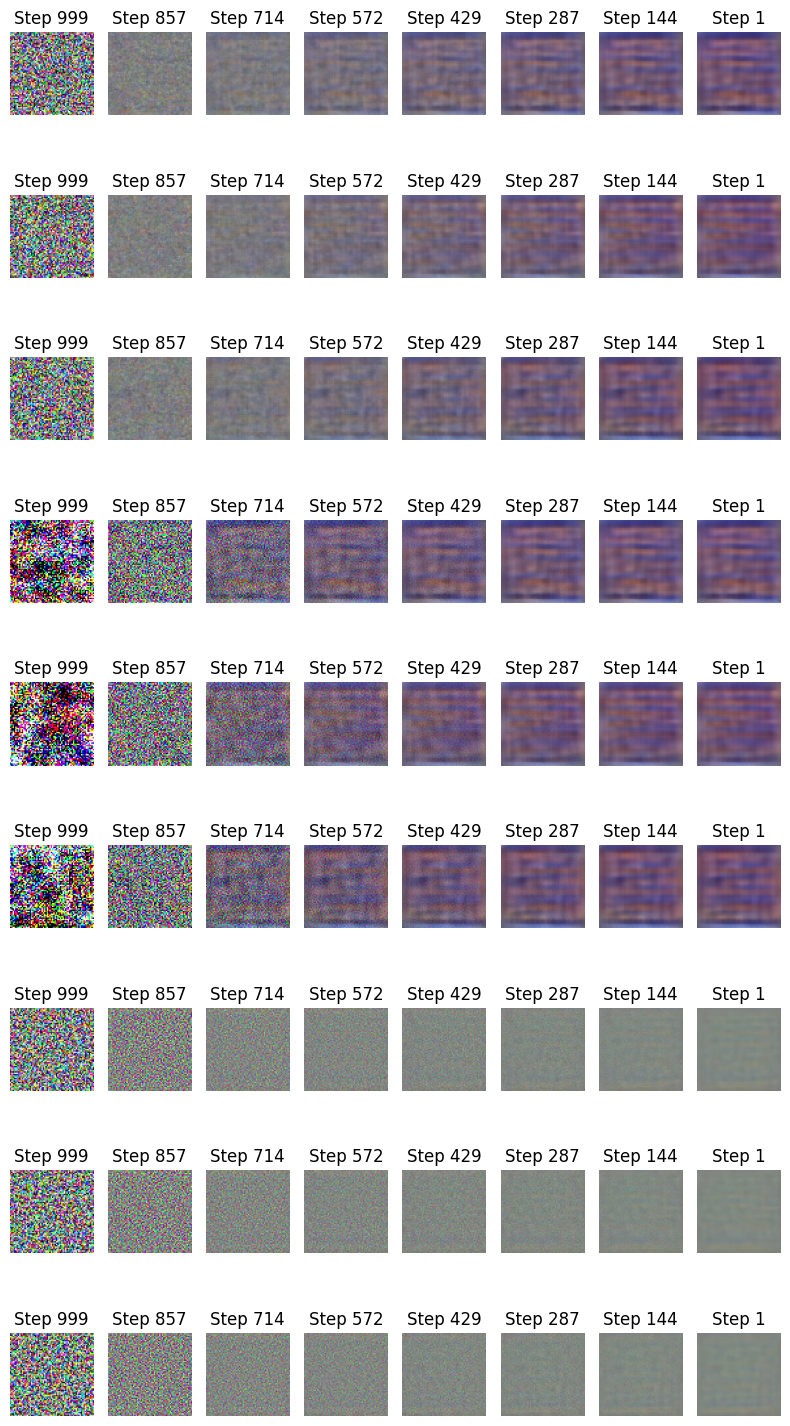

In [179]:

variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))

def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = tf.random.normal(xt.shape)
    else:
        randNoise= tf.zeros(xt.shape)

    # compute variance

    # predX0 = (1/np.sqrt(alphaBar[t])) * xt - np.sqrt(1.0-alphaBar[t])/np.sqrt(alphaBar[t]) * predNoise 
    # predX0  = 1/np.sqrt(alpha[t]) * (xt - beta[t]/np.sqrt(1-alphaBar[t]) * predNoise )
    # xtPrev = predX0 * (np.sqrt(alphaBar[t-1])*beta[t]) / ((1-alphaBar[t])) + xt*((1-alphaBar[t-1])*np.sqrt(alpha[t]))/((1-alphaBar[t])) + sigPred[t]*randNoise
       
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + variance[t] * randNoise
    # xtPrev = np.clip(xtPrev, -1.0, 1.0)

    return xtPrev, x0Pred



initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32) * np.sqrt(1-alphaBar[T-1])
samples = [initInput]
predictedX0s = []
predNoises=[]

for t in tqdm(np.arange(1,T)[::-1]):
    # print(samples[-1])
    pred = model((samples[-1], tf.constant([t, t, t])), training=False)
    xt = samples[-1]
    
    # sample, noise = backwardStep(xt, t, x0Pred=predX0)
    sample, predX0 = backwardStep(xt, t, predNoise=pred)

    samples.append(sample)
    predictedX0s.append(predX0)
    predNoises.append(pred)

_ = plt.figure(figsize=(12,8))

N = 8
sampleIdx = np.linspace(1, T-1, N)

plt.figure(figsize=(8,15))
for j in range(3):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(3,6):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predictedX0s[int(sampleIdx[i])-1])[j-3,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(6,9):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predNoises[int(sampleIdx[i])-1])[j-6,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
plt.tight_layout()

-2.6308937129652 2.4860148115630034


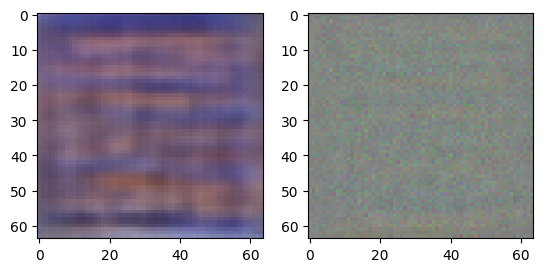

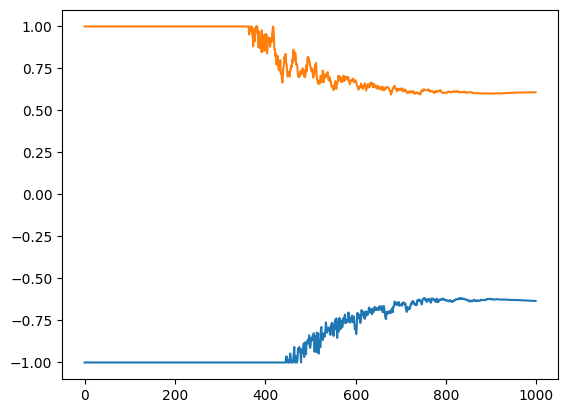

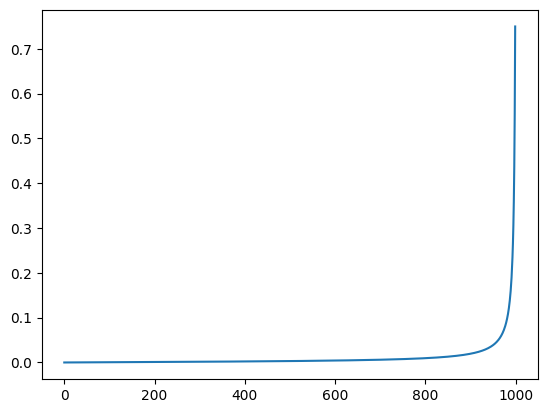

In [183]:
testT = 800
plt.subplot(1,2,1)
plt.imshow(postprocessImage(samples[testT])[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(postprocessImage(predNoises[testT])[0,:,:,:])
test = samples[0]

test = forwardStep(np.zeros((64,64)),500)[1]
print(np.min(test), np.max(test))

minVals=[]
maxVals=[]
for s in predictedX0s:
# for s in predNoises:
    minVals.append(np.min(s))
    maxVals.append(np.max(s))
plt.figure()
plt.plot(minVals)
_=plt.plot(maxVals)

plt.figure()
plt.plot(variance)

In [70]:
t=999
predX0 = 1/np.sqrt(alpha[t]) * (initInput - beta[t]/np.sqrt(1-alphaBar[t]) * predNoises[0] )
print(np.min(predX0), np.max(predX0))
print(np.min(predX0), np.max(predX0))
print(alphaBar[t])
print(1/np.sqrt(alpha[t]))
print(beta[t]/np.sqrt(1-alphaBar[t])*1/np.sqrt(alpha[t]))

-2.2925804 2.2123191
-2.2925804 2.2123191
2.4283894547995872e-06
1.999997571608889
1.4999987858020967


In [99]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


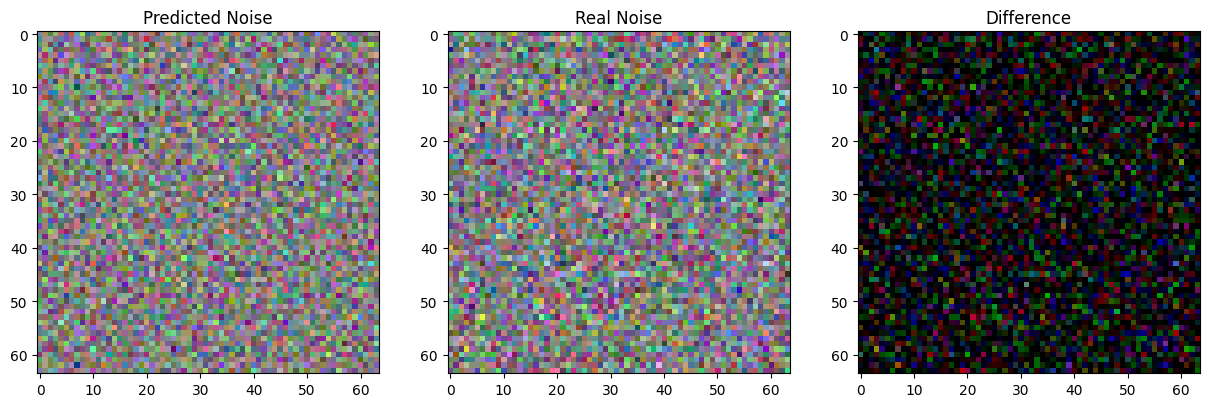

In [100]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+3)/6)
plt.title("Predicted Noise")
plt.subplot(1,3,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6)
plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6 - (predNoise.numpy()[0,:,:,:]+3)/6)

In [ ]:
t = 20
sigPred = np.sqrt(beta[t])

xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred*randNoise

return xtPrev

In [30]:
print(np.min(testNoise.numpy()))
print(np.max(testNoise.numpy()))

-3.0763395
3.490029


In [27]:
testTNum = testT.numpy()[0][0]